In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

In [10]:
stockName= "GE"
#loading the data from the folder and setting it up
df = pd.read_csv(os.path.join('Stocks',stockName+'.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
num_elem = int((sum(1 for line in open('Stocks/'+stockName+'.us.txt')) -1)/10)*10
print
print('Loaded data, total number of elements: ', num_elem)

Loaded data, total number of elements:  14050


In [11]:
#SORTING THE DATA BY DATE FOR LESS HEADACHE
df = df.sort_values('Date')

In [12]:
#checking the order of the data
df.head()

,Date,Open,High,Low,Close
0,1962-01-02,0.6277,0.6362,0.6201,0.6201
1,1962-01-03,0.6201,0.6201,0.6122,0.6201
2,1962-01-04,0.6201,0.6201,0.6037,0.6122
3,1962-01-05,0.6122,0.6122,0.5798,0.5957
4,1962-01-08,0.5957,0.5957,0.5716,0.5957


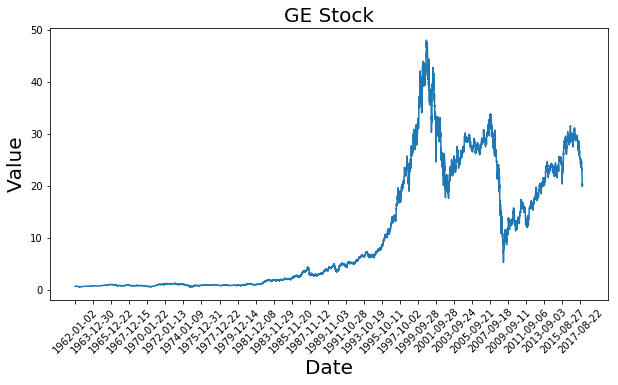

In [13]:
#visualizing the stock just to have an idea of what it looks like
plt.figure(figsize = (10,5))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title(stockName+" Stock",fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Value',fontsize=20)
plt.savefig('pics/'+stockName+'_price_history.png', bbox_inches='tight')
plt.show()

In [14]:
#calculating mid prices
mid_prices = (df.loc[:,'High'].values + df.loc[:,'Low'].values) /2.0

In [15]:
#splitting training set vs test data
d_train = mid_prices[:int(num_elem *.9) ]
d_test = mid_prices[int(num_elem*.9):]

In [16]:
#normalizing data using minMaxScaler()

scaler = MinMaxScaler()
d_train = d_train.reshape(-1,1)
d_test = d_test.reshape(-1,1)

In [17]:
#training scaler with training data
W_size = int(num_elem/5)
for i in range(0,W_size*4,W_size):
    scaler.fit(d_train[i:i+W_size,:])
    d_train[i:i+W_size,:]=scaler.transform(d_train[i:i+W_size,:])

scaler.fit(d_train[i+W_size:,:])
d_train[i+W_size:,:] = scaler.transform(d_train[i+W_size:,:])


In [18]:
#reshaping data and normaliing training data
d_train = d_train.reshape(-1)
d_test = scaler.transform(d_test).reshape(-1)


In [19]:
#Building EMA for standard averaging 
EMA = 0.0
gamma = 0.1
for ti in range(int(num_elem*.9 )):
    EMA = gamma*d_train[ti] + (1-gamma)*EMA
    d_train[ti] = EMA
m_data = np.concatenate([d_train,d_test],axis=0)

In [20]:
#Setting up window of days ahead standard averaging works for
window = 100
N = d_train.size 
std_pred = []
std_avg = []
mse_errors =[]
#training for one day ahead
for pred in range(window,N):
    if pred>=N:
        date =dt.datetime.strptime(k,'%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred,'Date']
    std_pred.append(np.mean(d_train[pred-window:pred]))
    mse_errors.append((std_pred[-1]-d_train[pred])**2)
    std_avg.append(date)
    print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00020
MSE error for standard averaging: 0.00028
MSE error for standard averaging: 0.00038
MSE error for standard averaging: 0.00051
MSE error for standard averaging: 0.00063
MSE error for standard averaging: 0.00073
MSE error for standard averaging: 0.00084
MSE error for standard averaging: 0.00096
MSE error for standard averaging: 0.00107
MSE error for standard averaging: 0.00118
MSE error for standard averaging: 0.00128
MSE error for standard averaging: 0.00137
MSE error for standard averaging: 0.00148
MSE error for standard averaging: 0.00159
MSE error for standard averaging: 0.00171
MSE error for standard averaging: 0.00183
MSE error for standard averaging: 0.00196
MSE error for standard averaging: 0.00209
MSE error for standard averaging: 0.00222
MSE error for standard averaging: 0.00236
MSE error for standard averaging: 0.00252
MSE error for standard averaging: 0.00271
MSE error for standard averaging: 0.00290
MSE error for standard averaging: 

MSE error for standard averaging: 0.00134
MSE error for standard averaging: 0.00135
MSE error for standard averaging: 0.00135
MSE error for standard averaging: 0.00136
MSE error for standard averaging: 0.00136
MSE error for standard averaging: 0.00137
MSE error for standard averaging: 0.00137
MSE error for standard averaging: 0.00137
MSE error for standard averaging: 0.00138
MSE error for standard averaging: 0.00138
MSE error for standard averaging: 0.00138
MSE error for standard averaging: 0.00138
MSE error for standard averaging: 0.00138
MSE error for standard averaging: 0.00138
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 0.00139
MSE error for standard averaging: 

MSE error for standard averaging: 0.00202
MSE error for standard averaging: 0.00202
MSE error for standard averaging: 0.00202
MSE error for standard averaging: 0.00203
MSE error for standard averaging: 0.00203
MSE error for standard averaging: 0.00204
MSE error for standard averaging: 0.00204
MSE error for standard averaging: 0.00204
MSE error for standard averaging: 0.00205
MSE error for standard averaging: 0.00205
MSE error for standard averaging: 0.00206
MSE error for standard averaging: 0.00206
MSE error for standard averaging: 0.00207
MSE error for standard averaging: 0.00207
MSE error for standard averaging: 0.00208
MSE error for standard averaging: 0.00208
MSE error for standard averaging: 0.00209
MSE error for standard averaging: 0.00209
MSE error for standard averaging: 0.00210
MSE error for standard averaging: 0.00210
MSE error for standard averaging: 0.00210
MSE error for standard averaging: 0.00211
MSE error for standard averaging: 0.00211
MSE error for standard averaging: 

MSE error for standard averaging: 0.00189
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00190
MSE error for standard averaging: 0.00191
MSE error for standard averaging: 0.00191
MSE error for standard averaging: 0.00191
MSE error for standard averaging: 0.00191
MSE error for standard averaging: 0.00191
MSE error for standard averaging: 0.00191
MSE error for standard averaging: 

MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00234
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00233
MSE error for standard averaging: 0.00232
MSE error for standard averaging: 0.00232
MSE error for standard averaging: 

MSE error for standard averaging: 0.00360
MSE error for standard averaging: 0.00360
MSE error for standard averaging: 0.00360
MSE error for standard averaging: 0.00360
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00359
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00358
MSE error for standard averaging: 0.00357
MSE error for standard averaging: 

MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00337
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 0.00336
MSE error for standard averaging: 

MSE error for standard averaging: 0.00313
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00312
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 0.00311
MSE error for standard averaging: 

MSE error for standard averaging: 0.00290
MSE error for standard averaging: 0.00290
MSE error for standard averaging: 0.00290
MSE error for standard averaging: 0.00290
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 0.00289
MSE error for standard averaging: 

MSE error for standard averaging: 0.00273
MSE error for standard averaging: 0.00273
MSE error for standard averaging: 0.00273
MSE error for standard averaging: 0.00273
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00272
MSE error for standard averaging: 0.00271
MSE error for standard averaging: 0.00271
MSE error for standard averaging: 0.00271
MSE error for standard averaging: 

MSE error for standard averaging: 0.00262
MSE error for standard averaging: 0.00262
MSE error for standard averaging: 0.00262
MSE error for standard averaging: 0.00262
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 

MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00250
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 0.00249
MSE error for standard averaging: 

MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00240
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 0.00241
MSE error for standard averaging: 

MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00260
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 0.00261
MSE error for standard averaging: 

MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 0.00439
MSE error for standard averaging: 

MSE error for standard averaging: 0.00425
MSE error for standard averaging: 0.00425
MSE error for standard averaging: 0.00425
MSE error for standard averaging: 0.00425
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00424
MSE error for standard averaging: 0.00423
MSE error for standard averaging: 0.00423
MSE error for standard averaging: 0.00423
MSE error for standard averaging: 0.00423
MSE error for standard averaging: 0.00423
MSE error for standard averaging: 

MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 

MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00400
MSE error for standard averaging: 0.00401
MSE error for standard averaging: 0.00401
MSE error for standard averaging: 0.00401
MSE error for standard averaging: 

MSE error for standard averaging: 0.00389
MSE error for standard averaging: 0.00389
MSE error for standard averaging: 0.00389
MSE error for standard averaging: 0.00389
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 0.00388
MSE error for standard averaging: 

MSE error for standard averaging: 0.00378
MSE error for standard averaging: 0.00378
MSE error for standard averaging: 0.00378
MSE error for standard averaging: 0.00378
MSE error for standard averaging: 0.00378
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 0.00377
MSE error for standard averaging: 

MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 0.00369
MSE error for standard averaging: 

MSE error for standard averaging: 0.00365
MSE error for standard averaging: 0.00365
MSE error for standard averaging: 0.00365
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 0.00364
MSE error for standard averaging: 

MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00355
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 0.00354
MSE error for standard averaging: 

MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00349
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 0.00348
MSE error for standard averaging: 

MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 0.00338
MSE error for standard averaging: 

MSE error for standard averaging: 0.00480
MSE error for standard averaging: 0.00480
MSE error for standard averaging: 0.00480
MSE error for standard averaging: 0.00480
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 0.00479
MSE error for standard averaging: 

MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00467
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 0.00466
MSE error for standard averaging: 

MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00457
MSE error for standard averaging: 0.00456
MSE error for standard averaging: 0.00456
MSE error for standard averaging: 0.00456
MSE error for standard averaging: 0.00456
MSE error for standard averaging: 0.00456
MSE error for standard averaging: 0.00456
MSE error for standard averaging: 

MSE error for standard averaging: 0.00449
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00448
MSE error for standard averaging: 0.00447
MSE error for standard averaging: 

MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 0.00440
MSE error for standard averaging: 

MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00436
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 0.00435
MSE error for standard averaging: 

MSE error for standard averaging: 0.00428
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 0.00427
MSE error for standard averaging: 

MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00415
MSE error for standard averaging: 0.00414
MSE error for standard averaging: 0.00414
MSE error for standard averaging: 0.00414
MSE error for standard averaging: 

MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00404
MSE error for standard averaging: 0.00403
MSE error for standard averaging: 0.00403
MSE error for standard averaging: 0.00403
MSE error for standard averaging: 0.00403
MSE error for standard averaging: 

MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00408
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 

MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 0.00405
MSE error for standard averaging: 

MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00413
MSE error for standard averaging: 0.00412
MSE error for standard averaging: 0.00412
MSE error for standard averaging: 0.00412
MSE error for standard averaging: 0.00412
MSE error for standard averaging: 0.00412
MSE error for standard averaging: 

MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00407
MSE error for standard averaging: 0.00406
MSE error for standard averaging: 

MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399
MSE error for standard averaging: 0.00399


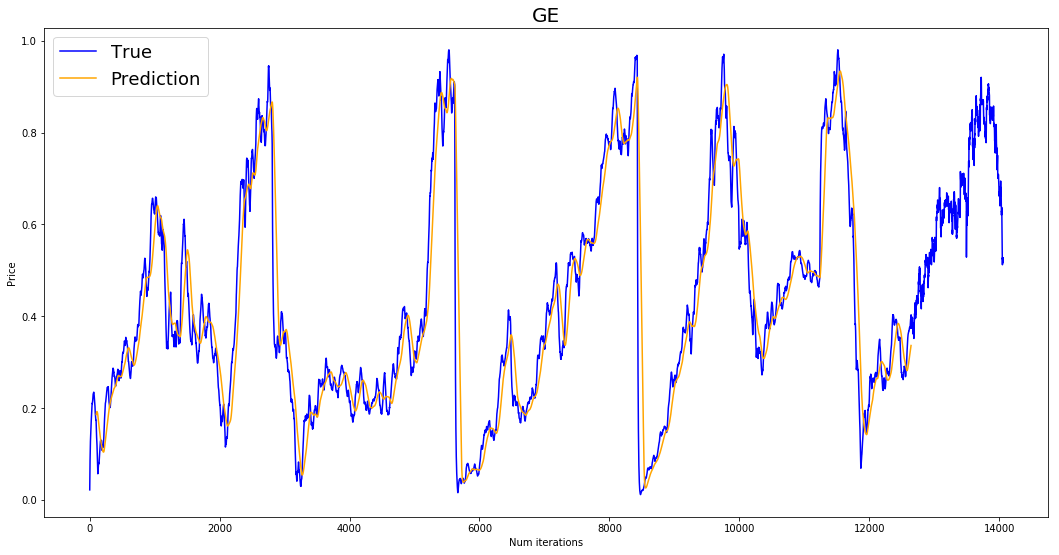

In [21]:
#plotting prediction vs true value for standard averaging 
plt.figure(figsize = (18,9))
plt.title(stockName,fontsize=20)
plt.plot(range(df.shape[0]),m_data,color='b',label='True')
plt.plot(range(window,N),std_pred,color='orange',label='Prediction')
plt.xlabel('Num iterations')
plt.ylabel('Price')
plt.legend(fontsize=18)
plt.savefig('pics/'+stockName+'__part2_prediction_to_true_Value_OnedayAhead.png', bbox_inches='tight')
plt.show()

In [22]:
#setting up exponential averaging
window = 100
N = d_train.size
avg_predictions = []
avg_x = []

mse_errors = []

mean = 0.0
avg_predictions.append(mean)

decay = 0.5

for pred in range(1,N):

    mean = mean*decay + (1.0-decay)*d_train[pred-1]
    avg_predictions.append(mean)
    mse_errors.append((avg_predictions[-1]-d_train[pred])**2)
    avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


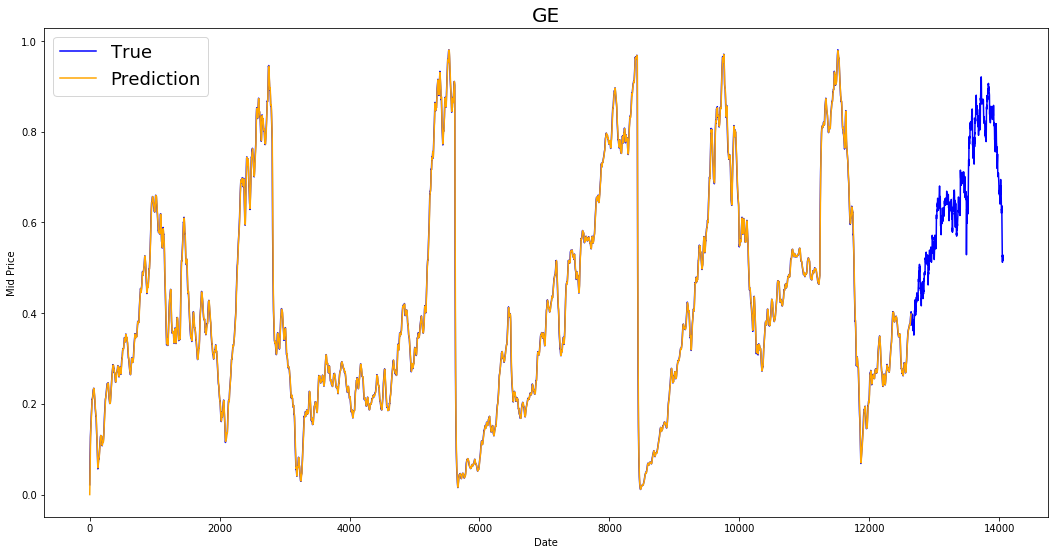

In [23]:
#plotting exponential averaging
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),m_data,color='b',label='True')
plt.plot(range(0,N),avg_predictions,color='orange', label='Prediction')
plt.title(stockName,fontsize=20)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.savefig('pics/'+stockName+'_price_prediction_avg_PART3.png', bbox_inches='tight')
plt.show()

In [24]:
#Creating a new class to use LSTMs to solve predictions for multiple days ahead
#setting up the parameters and hyperparameters
class d_Create(object):

    def __init__(self,prices,b_size,num_unroll):
        self._prices = prices
        self._len_prices = len(self._prices) - num_unroll
        self._b_size = b_size
        self._num_unroll = num_unroll
        self._iters = self._len_prices // self._b_size
        self._cursor = [offset * self._iters for offset in range(self._b_size)]

    def next_batch(self):

        b_data = np.zeros((self._b_size), dtype=np.float32)
        b_labels = np.zeros((self._b_size), dtype=np.float32)

        for b in range(self._b_size):
            if self._cursor[b]+1>=self._len_prices:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0, (b+1) * self._iters)

            b_data[b] = self._prices[self._cursor[b]]
            b_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._len_prices

        return b_data,b_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._b_size):
            self._cursor[b] = np.random.randint(0, min((b+1) * self._iters, self._len_prices - 1))



dg = d_Create(d_train, 5, 5)
u_data, u_labels = dg.unroll_batches()

for i, (dat, lbl) in enumerate(zip(u_data, u_labels)):
    print('\n\nUnrolled index %d' % i)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.02154714 0.708506   0.3546792  0.5802759  0.5988515 ]

	Output: [0.06690317 0.7015231  0.3557445  0.5802759  0.6034115 ]


Unrolled index 1
	Inputs:  [0.03941077 0.70483077 0.35664102 0.58092785 0.6005302 ]

	Output: [0.0760907  0.70483077 0.35664102 0.58173144 0.6043893 ]


Unrolled index 2
	Inputs:  [0.05494659 0.7015231  0.35616916 0.5816409  0.60191005]

	Output: [0.09523354 0.70058465 0.3557445  0.5816409  0.60191005]


Unrolled index 3
	Inputs:  [0.06690317 0.70058465 0.3557445  0.58196163 0.6034115 ]

	Output: [0.06690317 0.70058465 0.35481074 0.580043   0.60348487]


Unrolled index 4
	Inputs:  [0.0760907  0.70027506 0.35481074 0.58173144 0.6042338 ]

	Output: [0.08590102 0.7051022  0.35281324 0.5785238  0.60348487]


In [25]:
 D = 1  # Dimensionality of the data
num_unroll = 50  # Steps you look into the future.
bat_size = 500  #  Samples in a batch
num_nodes = [200, 200, 150]  # Hidden nodes in each layer
n_layers = len(num_nodes)  # Number of layers
dropout = 0.2  # dropout amount
tf.reset_default_graph()  

In [26]:
 # Input data
i_train, o_train = [], []

# You unroll the input over time defining placeholders for each time step
for i in range(num_unroll):
    i_train.append(tf.placeholder(tf.float32, shape=[bat_size, D], name='train_inputs_%d' % i))
    o_train.append(tf.placeholder(tf.float32, shape=[bat_size, 1], name='train_outputs_%d' % i))


In [27]:
#Setting up lstm cells, and w and b
lstm_cells = [
        tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                                state_is_tuple=True,
                                initializer=tf.contrib.layers.xavier_initializer()
                                )
for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w', shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b', initializer=tf.random_uniform([1], -0.1, 0.1))

In [28]:
 # Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [], []
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([bat_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([bat_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

    # Do  tensorflow transformations, for dynamic rnn. Also setting up the dropout 
    
inputs = tf.concat([tf.expand_dims(t, 0) for t in i_train], axis=0)

lstm_o, state = tf.nn.dynamic_rnn(
drop_multi_cell, inputs, initial_state=tuple(initial_state),
time_major=True, dtype=tf.float32)

lstm_o = tf.reshape(lstm_o, [bat_size * num_unroll, num_nodes[-1]])

outputs = tf.nn.xw_plus_b(lstm_o, w, b)

split_o = tf.split(outputs, num_unroll, axis=0)

In [29]:
# the sum of the mean error is the total loss 

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)] +
                                 [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for i in range(num_unroll):
        loss += tf.reduce_mean(0.5 * (split_o[i] - o_train[i]) ** 2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
gstep = tf.assign(global_step, global_step + 1)
tf_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)

learning_rate = tf.maximum(
        tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
        tf_min_learning_rate)

    # Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
grads, v = zip(*optimizer.compute_gradients(loss))
grads, _ = tf.clip_by_global_norm(grads, 5.0)
optimizer = optimizer.apply_gradients(
        zip(grads, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [30]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')



Defining prediction related TF functions
	All done


In [31]:
epochs = int(120000 / num_elem)

valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps continously predicting for 

train_seq_length = d_train.size# Training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2

print('Initialized')
average_loss = 0

# Define data generator
data_gen = d_Create(d_train,bat_size,num_unroll)
                    
x_axis_seq=[]

# Points you start your test predictions from
test_points_seq = np.arange(int(.85*num_elem),int(num_elem *.95),50).tolist()

for ep in range(epochs):       
    tmp = int(train_seq_length // bat_size)
    # training the LSTM
    for step in range(tmp): 
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[i_train[ui]] = dat.reshape(-1,1)
            feed_dict[o_train[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # Validating the LSTM
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//bat_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # Making predictions 
    
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          x_axis=[]

        for tr_i in range(w_i-num_unroll+1,w_i-1):
          current_price = m_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = m_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-m_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay 
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')
session.close()

Initialized
Average loss at step 1: 1.014157
	Test MSE: 0.00498
	Finished Predictions
Average loss at step 2: 0.133823
	Test MSE: 0.00162
	Finished Predictions
Average loss at step 3: 0.078942
	Test MSE: 0.00148
	Finished Predictions
Average loss at step 4: 0.065527
	Test MSE: 0.00068
	Finished Predictions
Average loss at step 5: 0.055365
	Test MSE: 0.00059
	Finished Predictions
Average loss at step 6: 0.047374
	Test MSE: 0.00055
	Finished Predictions
Average loss at step 7: 0.045632
	Test MSE: 0.00052
	Finished Predictions
Average loss at step 8: 0.039414
	Test MSE: 0.00048
	Finished Predictions


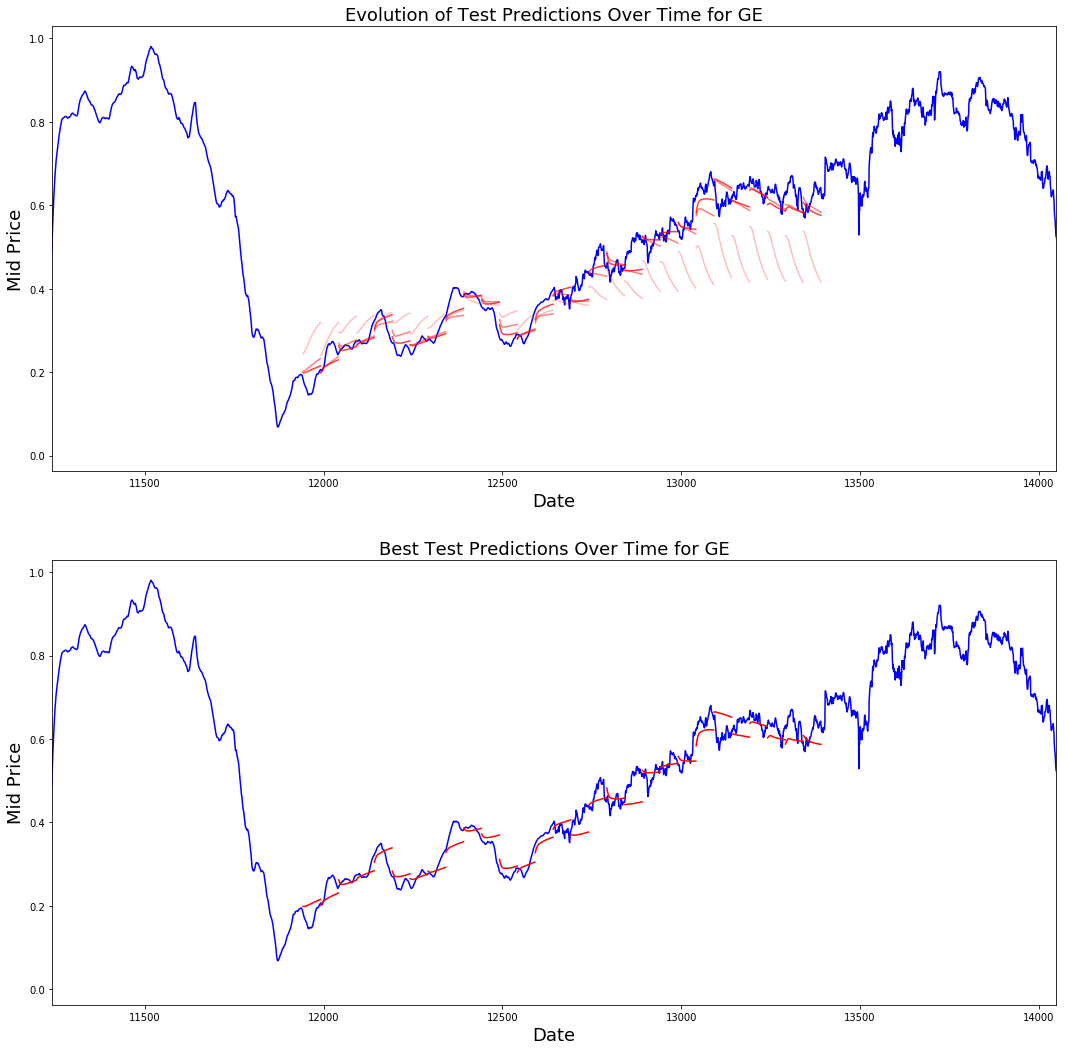

In [32]:
best_prediction = epochs-1  # best epoch with the lowest MSE 

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(range(df.shape[0]), m_data, color='b')

            # Plotting how the predictions change over time
start_alpha = .25
alpha = np.arange(start_alpha, 1.1, (1.0 - start_alpha) / len(predictions_over_time[::3]))
for p_i, p in enumerate(predictions_over_time[::3]):
    for xval, yval in zip(x_axis_seq, p):
        plt.plot(xval, yval, color='r', alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time for '+stockName, fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.xlim(int(num_elem*.80),int(num_elem))

plt.subplot(2, 1, 2)

            # Predicting the best test prediction
plt.plot(range(df.shape[0]), m_data, color='b')
for xval, yval in zip(x_axis_seq, predictions_over_time[best_prediction]):
    plt.plot(xval, yval, color='r')

plt.title('Best Test Predictions Over Time for '+stockName, fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.xlim(int(num_elem*.80),int(num_elem))
plt.savefig('pics/'+stockName+'_price_prediction_with_Apoche_part4.png', bbox_inches='tight')
plt.show()